In [287]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.ndimage as ndimage
import pymannkendall as mk


In [288]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
# dtype='str', comments="#", delimiter="\t", unpack=False)
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [289]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')

In [290]:
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,2017-01-10 18:00:00,1,1,28/12/2016 18:00,5,2017-01-11 14:00:00,FLAMI


In [291]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [292]:
# creating df for the time series data

PC_0192_data = pd.read_csv("PC0192_1_HR.csv", sep=',')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [293]:
# making sure 'record_date_time' is of the correct type

# PC_0192_data['record_date_time'] = PC_0192_data['record_date_time'].dt.strftime('%d/%m/%Y %H:%M:%S')
PC_0192_data['record_date_time'] = pd.to_datetime(PC_0192_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_data

,monitor,record_date_time,num_value
0,HR,2016-12-22 12:09:21,98
1,HR,2016-12-22 12:09:26,98
2,HR,2016-12-22 12:09:31,98
3,HR,2016-12-22 12:09:36,96
4,HR,2016-12-22 12:09:41,97
...,...,...,...
942176,HR,2017-02-18 17:08:34,96
942177,HR,2017-02-18 17:08:39,96
942178,HR,2017-02-18 17:08:44,95
942179,HR,2017-02-18 17:08:49,96


In [294]:
# 'failed_extubation' and 're_intubation' are formatted differently to 'PC_0192_data'
# change manually for now, BUT COME BACK TO THIS AND CHANGE PROPERLY

# failed_extubation_2 = '2017-01-10 18:00:00'
# re_intubation_2 = '2017-01-11 14:00:00'

# fixed this

In [295]:
# PC_0192_data.timestamp.searchsorted(failed_extubation)

In [296]:
# dt='2022-02-07T23:18:06.08349'
# PC_0192_data. timestamp.searchsorted(dt)

In [297]:
# np.where(PC_0192_data["record_date_time"] == test)[0]

In [298]:
# failed_extubation = pd.to_datetime(failed_extubation)
# s = PC_0192_data['record_date_time'].loc[PC_0192_data['record_date_time'].index.unique()[PC_0192_data['record_date_time'].index.unique().get_loc(failed_extubation, method='nearest')]]

In [299]:
# finding indexes at which failed_extubation and re_intubation would need to be inserted to maintain order

failed_extubation_index = PC_0192_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

320515 334633


In [300]:
# lifting data for the time peried where patient was extubated

PC_0192_extubated = PC_0192_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_extubated

,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,100
320517,HR,2017-01-10 18:00:11,100
320518,HR,2017-01-10 18:00:16,100
320519,HR,2017-01-10 18:00:21,100
320520,HR,2017-01-10 18:00:26,99
...,...,...,...
334627,HR,2017-01-11 13:59:32,121
334628,HR,2017-01-11 13:59:36,121
334629,HR,2017-01-11 13:59:42,121
334630,HR,2017-01-11 13:59:46,121


<AxesSubplot:xlabel='record_date_time'>

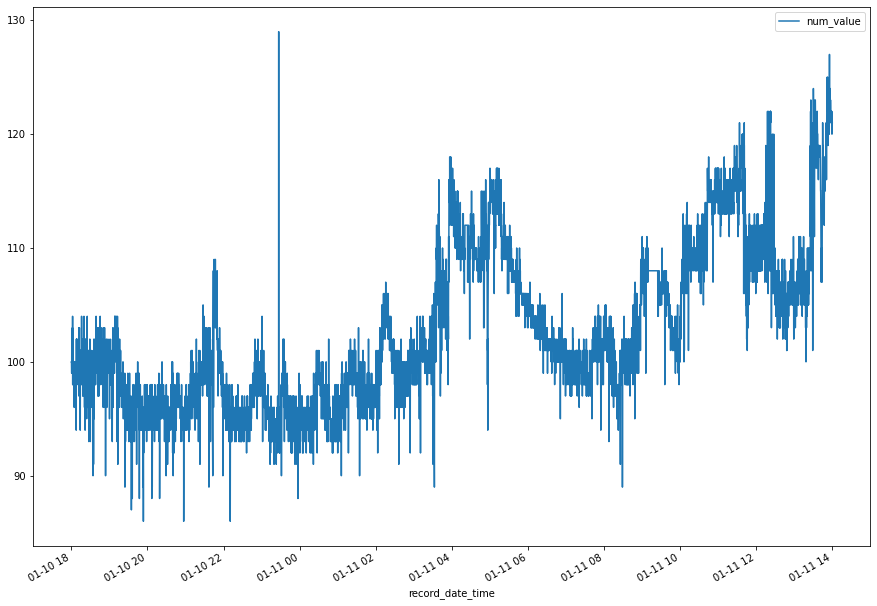

In [301]:
PC_0192_extubated.plot('record_date_time', 'num_value', figsize=(15, 11))

- anomalous point just before 01-11 00:00?
- leave as is for now

In [302]:
# use timedelta to add a period of time to a timestamp:

PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10)
PC_0192_extubated['record_date_time'].iloc[-1]

Timestamp('2017-01-11 13:59:52')

### Rolling mean:

In [303]:
# following has incorrect timestamps

# k = 0

# PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

# while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

#     index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
#     index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

#     mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

#     PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k),
#     'end_time':PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k), 'mean':mean}, ignore_index=True)
#     k += 1


In [304]:
k = 0

PC_0192_mean = pd.DataFrame(columns=['start_time','end_time','mean'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    mean = PC_0192_extubated['num_value'][index_1:index_2].mean(axis=0)

    PC_0192_mean = PC_0192_mean.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
    k += 1

In [305]:
PC_0192_extubated['record_date_time'].iloc[index_1]

Timestamp('2017-01-11 13:49:07')

In [306]:
PC_0192_mean

,start_time,end_time,mean
0,2017-01-10 18:00:06,2017-01-10 18:10:06,99.521008
1,2017-01-10 18:01:06,2017-01-10 18:11:06,99.487395
2,2017-01-10 18:02:11,2017-01-10 18:12:06,99.344538
3,2017-01-10 18:03:06,2017-01-10 18:13:06,99.383333
4,2017-01-10 18:04:06,2017-01-10 18:14:06,99.4
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,119.408333
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,119.916667
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,120.483333
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,121.075


In [307]:
# PC_0192_mean.plot(x='start_time', y='mean')

# TypeError: no numeric data to plot

In [308]:
index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=540+k))

mean = PC_0192_extubated['num_value'][index_1:index_2].mean()
mean

121.98305084745763

In [309]:
PC_0192_mean.dtypes

start_time    datetime64[ns]
end_time      datetime64[ns]
mean                  object
dtype: object

In [310]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [311]:
PC_0192_mean.iloc[910]

start_time    2017-01-11 09:24:32
end_time      2017-01-11 09:24:32
mean                          NaT
Name: 910, dtype: object

In [312]:
# PC_0192_mean = PC_0192_mean.drop(910)

In [313]:
# PC_0192_mean.plot(x='start_time', y='mean')

In [314]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

In [315]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_mean['mean']):
    if pd.isnull(row):
        PC_0192_mean = PC_0192_mean.drop(i)

In [316]:
# PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

# TypeError: Invalid object type at position 910

The correlation coefficient of the mean is 1.0 which is strong positive.


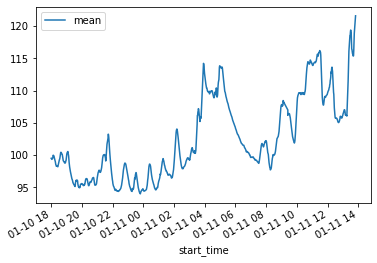

In [317]:
PC_0192_mean['mean'] = pd.to_numeric(PC_0192_mean['mean'])

PC_0192_mean.plot(x='start_time', y='mean')

print(f"The correlation coefficient of the mean is {PC_0192_mean.corr()['mean'][0]} which is strong positive.")

don't really understand significance of increasing mean COME BACK TO THIS!

### Rolling variance (intervals of 10 mins):

In [318]:
k = 0

PC_0192_var_10_min = pd.DataFrame(columns=['start_time','end_time','variance'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=10+k))

    var = PC_0192_extubated['num_value'][index_1:index_2].var(axis=0)

    PC_0192_var_10_min = PC_0192_var_10_min.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
    k += 1


In [319]:
PC_0192_var_10_min

,start_time,end_time,variance
0,2017-01-10 18:00:06,2017-01-10 18:10:06,1.963538
1,2017-01-10 18:01:06,2017-01-10 18:11:06,1.963823
2,2017-01-10 18:02:11,2017-01-10 18:12:06,1.685372
3,2017-01-10 18:03:06,2017-01-10 18:13:06,1.683754
4,2017-01-10 18:04:06,2017-01-10 18:14:06,1.939496
...,...,...,...
1185,2017-01-11 13:45:07,2017-01-11 13:55:07,9.520938
1186,2017-01-11 13:46:07,2017-01-11 13:56:06,10.497199
1187,2017-01-11 13:47:07,2017-01-11 13:57:06,10.503922
1188,2017-01-11 13:48:07,2017-01-11 13:58:07,8.053151


In [320]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_var_10_min['variance']):
    if pd.isnull(row):
        PC_0192_var_10_min = PC_0192_var_10_min.drop(i)

<AxesSubplot:xlabel='start_time'>

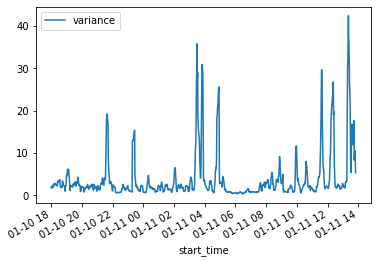

In [321]:
PC_0192_var_10_min['variance'] = pd.to_numeric(PC_0192_var_10_min['variance'])

PC_0192_var_10_min.plot(x='start_time', y='variance')

rough notes:

- patches of low variance throughout
- but we generally see higher variances closer to the critical point (lower resilience)
- this suggests the critical slowing down begins quite early on, in this case variance gets relatively high about 11 hours before critical point

### Rolling variance (intervals of 1 hour):

In [322]:
k = 0

PC_0192_var_1_hour = pd.DataFrame(columns=['start_time','end_time','variance'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k))

    var = PC_0192_extubated['num_value'][index_1:index_2].var(axis=0)

    PC_0192_var_1_hour = PC_0192_var_1_hour.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
    k += 1

In [323]:
PC_0192_var_1_hour

,start_time,end_time,variance
0,2017-01-10 18:00:06,2017-01-10 19:00:10,2.794764
1,2017-01-10 18:01:06,2017-01-10 19:01:10,2.812136
2,2017-01-10 18:02:11,2017-01-10 19:02:10,2.756124
3,2017-01-10 18:03:06,2017-01-10 19:03:10,2.717823
4,2017-01-10 18:04:06,2017-01-10 19:04:10,2.724989
...,...,...,...
1135,2017-01-11 12:55:08,2017-01-11 13:55:07,43.828784
1136,2017-01-11 12:56:08,2017-01-11 13:56:06,45.213919
1137,2017-01-11 12:57:08,2017-01-11 13:57:06,46.413874
1138,2017-01-11 12:58:08,2017-01-11 13:58:07,46.996571


In [324]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_var_1_hour['variance']):
    if pd.isnull(row):
        PC_0192_var_1_hour = PC_0192_var_1_hour.drop(i)

The correlation coefficient of the variance is 1.0 which is strong positive.


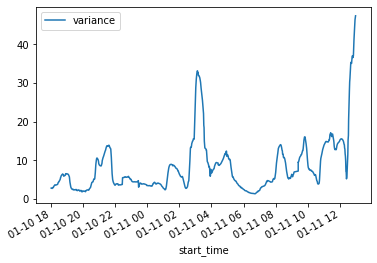

In [325]:
PC_0192_var_1_hour['variance'] = pd.to_numeric(PC_0192_var_1_hour['variance'])

PC_0192_var_1_hour.plot(x='start_time', y='variance')

print(f"The correlation coefficient of the variance is {PC_0192_var_1_hour.corr()['variance'][0]} which is strong positive.")

### Autocorrelation:

In [326]:
idx1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0])
idx2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=20))

idx3 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[-1] - timedelta(minutes=20))
idx4 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[-1])


# pd.plotting.lag_plot(PC_0192_extubated['num_value'][idx1:idx2], lag=1)
# print(f"Autocorrelation for first 20 mins: {PC_0192_extubated['num_value'][idx1:idx2].autocorr()}")

Autocorrelation for first 20 mins: 0.4416100898040873


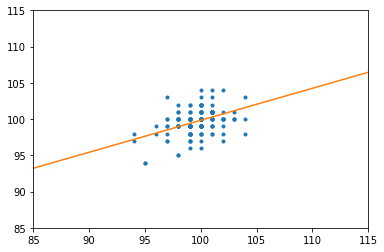

In [327]:
plt.plot(PC_0192_extubated['num_value'][idx1:idx2], PC_0192_extubated['num_value'][idx1+1:idx2+1], '.')

theta = np.polyfit(PC_0192_extubated['num_value'][idx1:idx2], PC_0192_extubated['num_value'][idx1+1:idx2+1], 1)
line_of_best_fit1 = theta[1] + theta[0] * np.linspace(85,115,400)

plt.plot(np.linspace(85,115,400), line_of_best_fit1)

plt.xlim(xmin=85,xmax=115)
plt.ylim(ymin=85,ymax=115)

print(f"Autocorrelation for first 20 mins: {PC_0192_extubated['num_value'][idx1:idx2].autocorr()}")

Autocorrelation for final 20 mins: 0.970008205179185


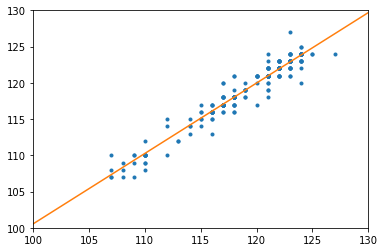

In [328]:
plt.plot(PC_0192_extubated['num_value'][idx3-1:idx4-1], PC_0192_extubated['num_value'][idx3:idx4], '.')

theta = np.polyfit(PC_0192_extubated['num_value'][idx3-1:idx4-1], PC_0192_extubated['num_value'][idx3:idx4], 1)
line_of_best_fit2 = theta[1] + theta[0] * np.linspace(100,130,400)

plt.plot(np.linspace(100,130,400), line_of_best_fit2)

plt.xlim(xmin=100,xmax=130)
plt.ylim(ymin=100,ymax=130)

print(f"Autocorrelation for final 20 mins: {PC_0192_extubated['num_value'][idx3:idx4].autocorr()}")

results as expected!
(10 mins looked like too few data points so used the initial and finial 20 mins to data points)

In [329]:
k = 0

PC_0192_ac_1_hour = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

while (PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k)) < PC_0192_extubated['record_date_time'].iloc[-1]:

    index_1 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=k))
    index_2 = PC_0192_extubated.record_date_time.searchsorted(PC_0192_extubated['record_date_time'].iloc[0] + timedelta(minutes=60+k))

    ac = PC_0192_extubated['num_value'][index_1:index_2].autocorr()

    PC_0192_ac_1_hour = PC_0192_ac_1_hour.append({'start_time': PC_0192_extubated['record_date_time'].iloc[index_1], 'end_time':PC_0192_extubated['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
    k += 1

In [330]:
# systematically removing NaT rows

for i, row in enumerate(PC_0192_ac_1_hour['autocorrelation']):
    if pd.isnull(row):
        PC_0192_ac_1_hour = PC_0192_ac_1_hour.drop(i)

The correlation coefficient of the autocorrelation is 1.0 which is strong positive.


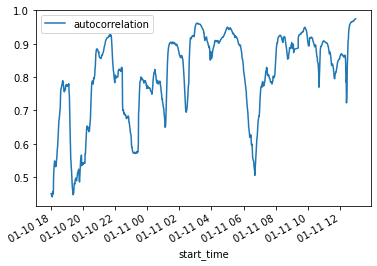

In [331]:
PC_0192_ac_1_hour['autocorrelation'] = pd.to_numeric(PC_0192_ac_1_hour['autocorrelation'])

PC_0192_ac_1_hour.plot(x='start_time', y='autocorrelation')

# theta = np.polyfit(enumerate(PC_0192_ac_1_hour['autocorrelation'])[0], enumerate(PC_0192_ac_1_hour['autocorrelation'])[1], 1)
# line_of_best_fit2 = theta[1] + theta[0] * np.linspace(1,100,400)

# plt.plot(np.linspace(1,100,400), line_of_best_fit2)

print(f"The correlation coefficient of the autocorrelation is {PC_0192_ac_1_hour.corr()['autocorrelation'][0]} which is strong positive.")

general upwards trend?

### Making this into a function:

In [332]:
def rolling_mean(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','mean'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        mean = data['num_value'][index_1:index_2].mean()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['mean']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['mean'] = pd.to_numeric(df['mean'])

    df.plot(x='start_time', y='mean', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['mean'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['mean'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['mean'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['mean'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.6079577215638184, and the p-value is 1.1709956691104076e-196.
The Hamid and Rao correction relusts in a p-value of 1.0428550778485146e-07
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=1.0428550778485146e-07, z=5.319093548282201, Tau=0.6080561562489273, s=354290.0, var_s=4436495855.792175, slope=0.013871106247873128, intercept=93.47621291154074)


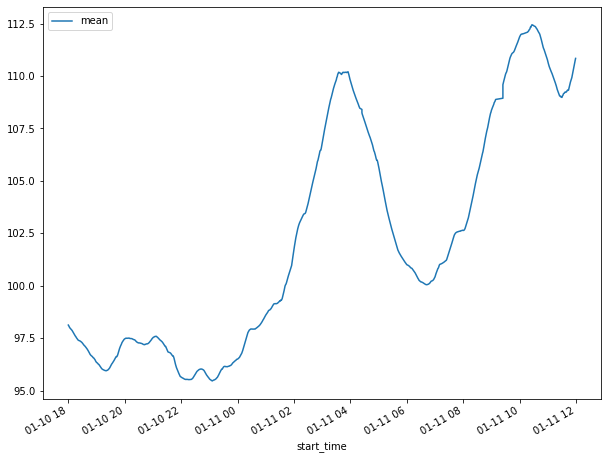

In [333]:
rolling_mean(PC_0192_extubated, 120)

increasing mean could be known expected i.e: heart rate goes up before the critical point

In [334]:
def rolling_variance(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'variance'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','variance'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        var = data['num_value'][index_1:index_2].var()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['variance']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['variance'] = pd.to_numeric(df['variance'])

    df.plot(x='start_time', y='variance', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the variance is {stats.kendalltau(df['start_time'], df['variance'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['variance'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['variance'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['variance'])}")

        

The kendall tau correlation coefficient of the variance is 0.3668529583600319, and the p-value is 7.463802251160827e-73.
The Hamid and Rao correction relusts in a p-value of 5.7088586030040744e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=5.7088586030040744e-05, z=4.024532599255757, Tau=0.3670047712216387, s=213839.0, var_s=2823181949.082718, slope=0.011269249843240403, intercept=3.1459322236633405)


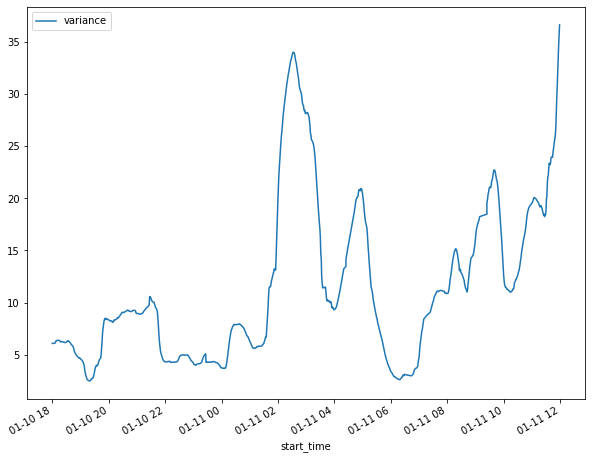

In [335]:
rolling_variance(PC_0192_extubated, 120)

In [336]:
def rolling_autocorrelation(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.3726970886514456, and the p-value is 3.919415888662201e-75.
The Hamid and Rao correction relusts in a p-value of 0.0022192376840606265
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0022192376840606265, z=3.059206976844212, Tau=0.3728040366594583, s=217218.0, var_s=5041617584.0123, slope=0.0001422504460582358, intercept=0.8162803131854769)


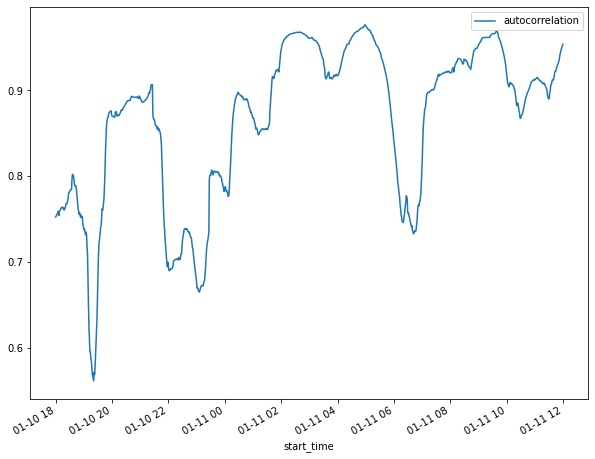

In [337]:
rolling_autocorrelation(PC_0192_extubated, 120)

In [339]:
# result = mk.hamed_rao_modification_test(data)
# print(result)

### Gaussian smoothing

https://towardsdatascience.com/gaussian-smoothing-in-time-series-data-c6801f8a4dc3

In [340]:
PC_0192_data_smoothed = PC_0192_data.copy()
PC_0192_data_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_data['num_value'], sigma=100)
print(ndimage.gaussian_filter1d(PC_0192_data['num_value'], 2))

[97 97 97 ... 95 95 95]


In [341]:
PC_0192_extubated_smoothed = PC_0192_data_smoothed.iloc[failed_extubation_index+1:re_intubation_index-1, :]

print(max(PC_0192_extubated['num_value'] - PC_0192_extubated_smoothed['num_value']))

34


The kendall tau correlation coefficient of the autocorrelation is 0.6140470134178728, and the p-value is 1.4928071951129554e-200.
The Hamid and Rao correction relusts in a p-value of 8.927326478058717e-08
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=8.927326478058717e-08, z=5.347305495445583, Tau=0.6141094291696702, s=357817.0, var_s=4477643573.357839, slope=0.014004629629629525, intercept=92.95455035461508)


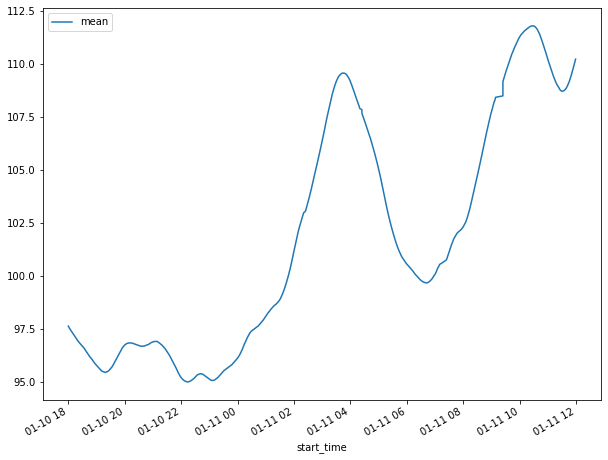

In [481]:
rolling_mean(PC_0192_extubated_smoothed, 120)

The kendall tau correlation coefficient of the variance is 0.35102420661128186, and the p-value is 7.391772632366862e-67.
The Hamid and Rao correction relusts in a p-value of 3.7161044800448906e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=3.7161044800448906e-05, z=4.124456974265389, Tau=0.3511773590086843, s=204617.0, var_s=2461192743.7859116, slope=0.006405334870310377, intercept=0.6060163720266214)


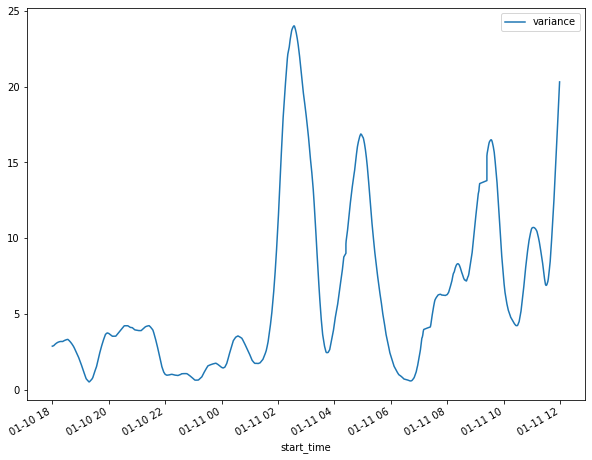

In [482]:
rolling_variance(PC_0192_extubated_smoothed, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.21255121585177755, and the p-value is 1.3254121748073182e-25.
The Hamid and Rao correction relusts in a p-value of 0.019415542180910794
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.019415542180910794, z=2.337454922923418, Tau=0.21269179281227474, s=123927.0, var_s=2810854563.3741407, slope=6.836901389216088e-07, intercept=0.9986270909842048)


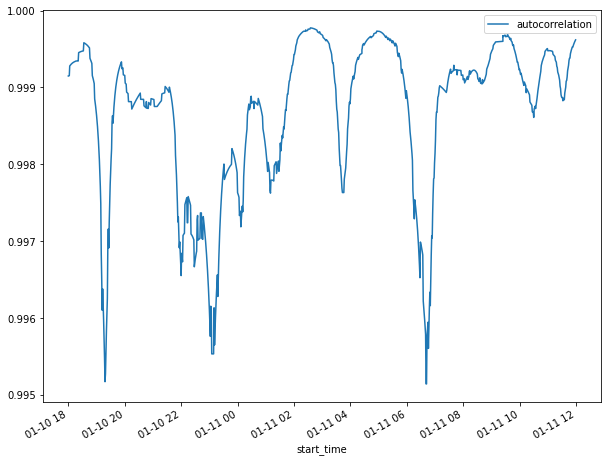

In [483]:
rolling_autocorrelation(PC_0192_extubated_smoothed, 120)

### Finding and analysing residuals

In [484]:
PC_0192_extubated_residuals = PC_0192_extubated.copy()

PC_0192_mean_smoothed = PC_0192_mean.copy()
PC_0192_mean_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_mean['mean'], sigma=100)

PC_0192_extubated_residuals['num_value'] = PC_0192_extubated['num_value'].subtract(PC_0192_mean_smoothed['mean'])

PC_0192_mean_smoothed['mean']

# would need to interpolate/resample using this method so instead smooth the initial time series data

0        99.521008
1        99.487395
2        99.344538
3        99.383333
4        99.400000
           ...    
1185    119.408333
1186    119.916667
1187    120.483333
1188    121.075000
1189    121.600000
Name: mean, Length: 1185, dtype: float64

In [485]:
PC_0192_residuals = PC_0192_extubated.copy()
PC_0192_residuals['num_value'] = PC_0192_extubated['num_value'] - PC_0192_extubated_smoothed['num_value']
PC_0192_residuals


,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,0
320517,HR,2017-01-10 18:00:11,0
320518,HR,2017-01-10 18:00:16,0
320519,HR,2017-01-10 18:00:21,0
320520,HR,2017-01-10 18:00:26,-1
...,...,...,...
334627,HR,2017-01-11 13:59:32,2
334628,HR,2017-01-11 13:59:36,2
334629,HR,2017-01-11 13:59:42,2
334630,HR,2017-01-11 13:59:46,2


The kendall tau correlation coefficient of the autocorrelation is -0.21059236792832056, and the p-value is 3.7193992774640377e-25.
The Hamid and Rao correction relusts in a p-value of 3.74189396852298e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=3.74189396852298e-05, z=-4.122864767952334, Tau=-0.21063742148079498, s=-122730.0, var_s=886127493.1412896, slope=-9.252962851819613e-05, intercept=0.5452236311319176)


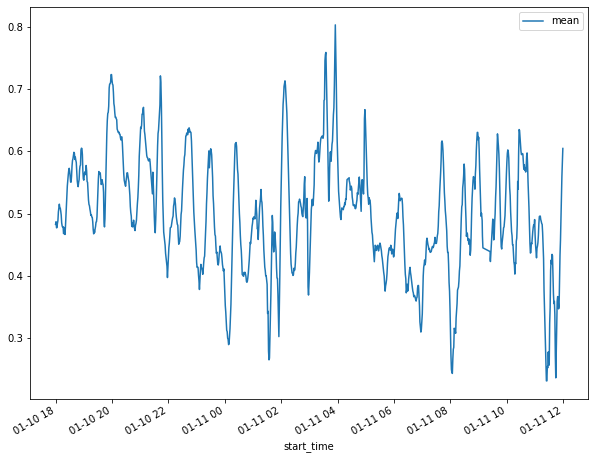

In [486]:
rolling_mean(PC_0192_residuals, 120)

The kendall tau correlation coefficient of the variance is 0.18184377305823615, and the p-value is 3.5984997796377676e-19.
The Hamid and Rao correction relusts in a p-value of 0.11937368577710039
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.11937368577710039, z=1.5574078406734448, Tau=0.1816359454913672, s=105832.0, var_s=4617650787.19442, slope=0.0014059797745702698, intercept=2.396027536513267)


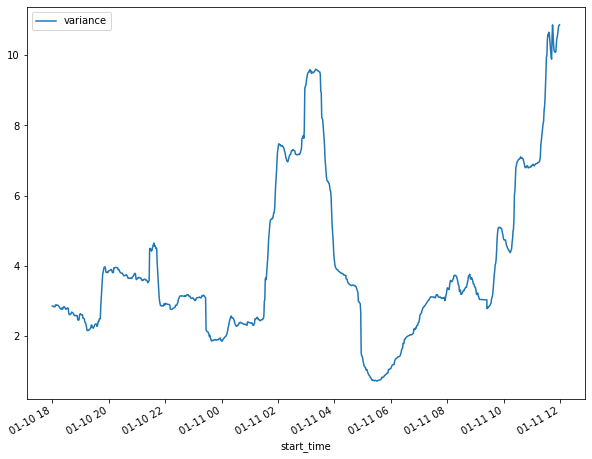

In [487]:
rolling_variance(PC_0192_residuals, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.3334663581924342, and the p-value is 1.6194054706174654e-60.
The Hamid and Rao correction relusts in a p-value of 0.0016303465784941462
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0016303465784941462, z=3.1504222257473793, Tau=0.333250952528061, s=194172.0, var_s=3798666870.8042583, slope=0.0002301023743832364, intercept=0.5960785315181526)


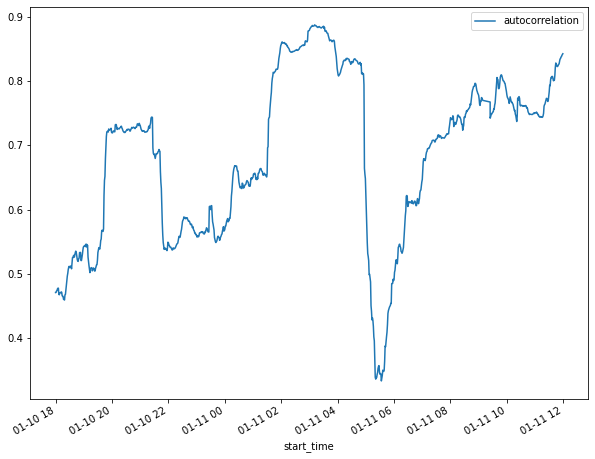

In [488]:
rolling_autocorrelation(PC_0192_residuals, 120)

<AxesSubplot:xlabel='record_date_time'>

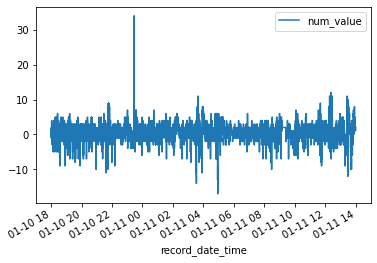

In [489]:
PC_0192_residuals.plot(x='record_date_time', y='num_value')

In [490]:
PC_0192_residuals

,monitor,record_date_time,num_value
320516,HR,2017-01-10 18:00:06,0
320517,HR,2017-01-10 18:00:11,0
320518,HR,2017-01-10 18:00:16,0
320519,HR,2017-01-10 18:00:21,0
320520,HR,2017-01-10 18:00:26,-1
...,...,...,...
334627,HR,2017-01-11 13:59:32,2
334628,HR,2017-01-11 13:59:36,2
334629,HR,2017-01-11 13:59:42,2
334630,HR,2017-01-11 13:59:46,2


smoothed the data using gaussian package for now - come back and do this by averaging over windows!!!

### Removing outliers

In [491]:
mu = PC_0192_extubated_smoothed['num_value'].mean()
sigma = PC_0192_extubated_smoothed['num_value'].std()
mu-3*sigma

83.02933330597907

In [492]:
# replacing values outside of mu+-2sigma with the mean of the values either side

PC_0192_extubated_smoothed_no_anomalies = PC_0192_extubated_smoothed.copy()

# idx = 0

for idx, val in enumerate(PC_0192_extubated_smoothed_no_anomalies['num_value']):
    if not (mu - 3*sigma < val < mu + 3*sigma):
        PC_0192_extubated_smoothed_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_extubated_smoothed['num_value'].iloc[idx+1] + PC_0192_extubated_smoothed['num_value'].iloc[idx-1])


In [493]:
# for val in PC_0192_extubated_smoothed_no_anomalies['num_value']:
#     print(val)

<AxesSubplot:xlabel='record_date_time'>

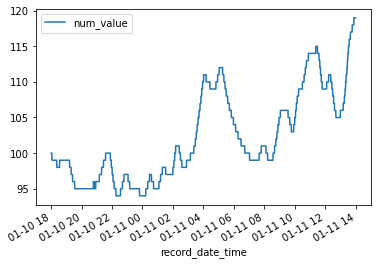

In [494]:
# print(max(PC_0192_extubated_smoothed_no_anomalies['num_value']-PC_0192_extubated_smoothed['num_value']))
PC_0192_extubated_smoothed_no_anomalies.plot(x='record_date_time', y='num_value')

<AxesSubplot:xlabel='record_date_time'>

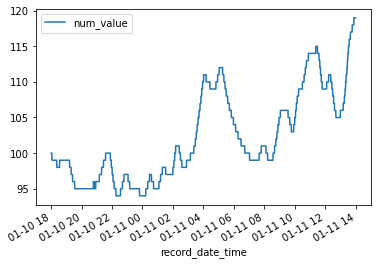

In [496]:
PC_0192_extubated_smoothed.plot(x='record_date_time', y='num_value')

In [495]:
mu_residual = PC_0192_residuals['num_value'].mean()
sigma_residual = PC_0192_residuals['num_value'].std()
mu_residual+3*sigma_residual

6.744413040734652

In [400]:
for idx, val in enumerate(PC_0192_extubated_smoothed_no_anomalies['num_value']):
    print(idx, val)

0 97
1 97
2 97
3 97
4 97
5 97
6 97
7 97
8 97
9 97
10 97
11 97
12 97
13 97
14 97
15 97
16 97
17 97
18 97
19 97
20 97
21 97
22 97
23 97
24 97
25 97
26 97
27 97
28 97
29 97
30 97
31 97
32 97
33 97
34 97
35 97
36 97
37 97
38 97
39 97
40 97
41 97
42 97
43 97
44 97
45 97
46 97
47 97
48 97
49 97
50 97
51 97
52 97
53 97
54 97
55 97
56 97
57 97
58 97
59 97
60 97
61 97
62 97
63 97
64 97
65 97
66 97
67 97
68 97
69 97
70 97
71 97
72 97
73 97
74 97
75 97
76 97
77 97
78 97
79 97
80 97
81 97
82 97
83 97
84 97
85 97
86 97
87 97
88 97
89 97
90 97
91 97
92 97
93 97
94 97
95 97
96 97
97 97
98 97
99 97
100 97
101 97
102 97
103 97
104 97
105 97
106 97
107 97
108 97
109 97
110 97
111 97
112 97
113 97
114 97
115 97
116 97
117 97
118 97
119 97
120 97
121 97
122 97
123 97
124 97
125 97
126 97
127 97
128 97
129 97
130 97
131 97
132 97
133 97
134 97
135 97
136 97
137 97
138 97
139 97
140 97
141 97
142 97
143 97
144 97
145 97
146 97
147 97
148 97
149 97
150 97
151 97
152 97
153 97
154 97
155 97
156 97
157 97
158 

<AxesSubplot:xlabel='record_date_time'>

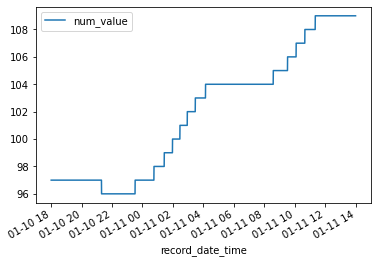

In [478]:
PC_0192_extubated_smoothed.plot(x='record_date_time', y='num_value')

### Removing anomalies from residuals

In [502]:
PC_0192_residuals_no_anomalies = PC_0192_residuals.copy()

# idx = 0

for idx, val in enumerate(PC_0192_residuals_no_anomalies['num_value']):
    if not (mu_residual - 3*sigma_residual < val < mu_residual + 3*sigma_residual):
        if idx == 0:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_residuals['num_value'].iloc[idx+1]
        if idx == 14116:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_residuals['num_value'].iloc[idx-1]
        else:
            PC_0192_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_residuals['num_value'].iloc[idx+1] + PC_0192_residuals['num_value'].iloc[idx-1])


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='record_date_time'>

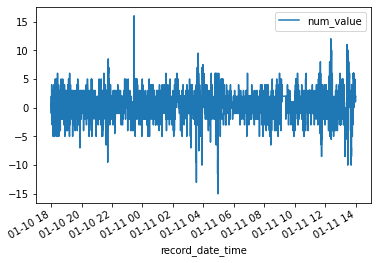

In [503]:
PC_0192_residuals_no_anomalies.plot(x='record_date_time', y='num_value')

The kendall tau correlation coefficient of the autocorrelation is -0.2582963753587517, and the p-value is 5.2512862375533705e-37.
The Hamid and Rao correction relusts in a p-value of 0.00021481448497717714
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='decreasing', h=True, p=0.00021481448497717714, z=-3.700925569098241, Tau=-0.2583668005354752, s=-150540.0, var_s=1654540307.3321786, slope=-0.00012439775248968888, intercept=0.5791327803916582)


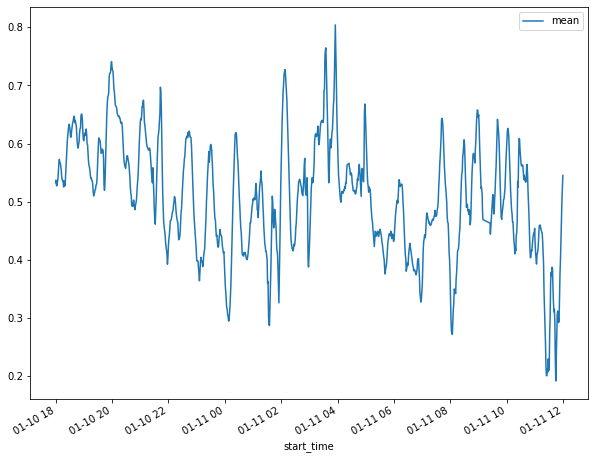

In [504]:
rolling_mean(PC_0192_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the variance is 0.2509644203974201, and the p-value is 4.86360944615869e-35.
The Hamid and Rao correction relusts in a p-value of 0.028063167007476242
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.028063167007476242, z=2.1964022186290384, Tau=0.2507500085813339, s=146102.0, var_s=4424687766.16985, slope=0.0015174255888949224, intercept=2.017579752118987)


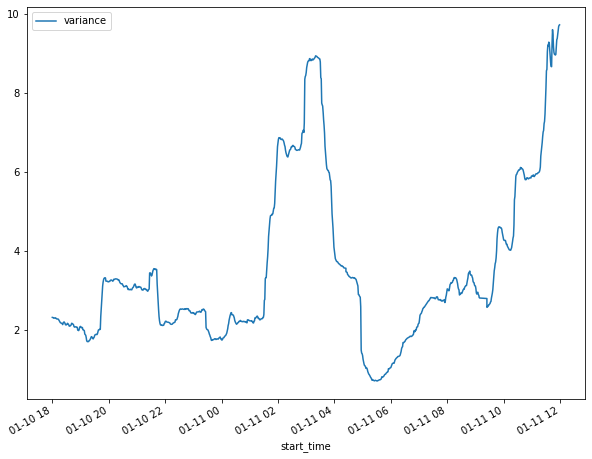

In [505]:
rolling_variance(PC_0192_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.3172838535211199, and the p-value is 5.868625423054345e-55.
The Hamid and Rao correction relusts in a p-value of 0.0010411659590177091
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0010411659590177091, z=3.279159975263558, Tau=0.317066556825593, s=184742.0, var_s=3173959430.9946313, slope=0.0002278530992805402, intercept=0.6180503464284836)


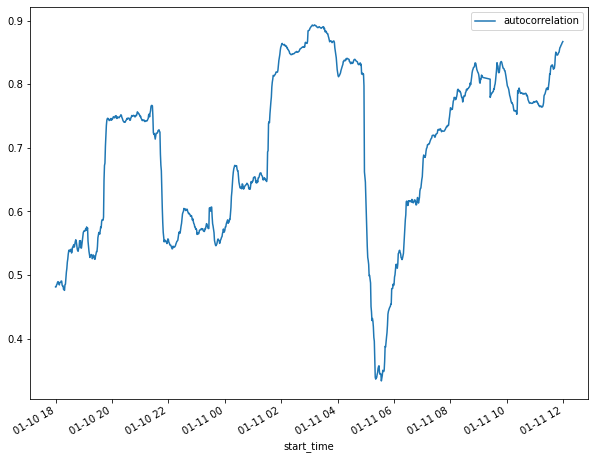

In [506]:
rolling_autocorrelation(PC_0192_residuals_no_anomalies, 120)